This notebook is for taking statistics over thousands of runs, in order to analyze which maze features (e.g. distance to cheese) tend to affect decision-making. 

In [1]:
try:
    import procgen_tools
except ImportError:
    get_ipython().run_line_magic(
        magic_name="pip",
        line="install -U git+https://github.com/ulissemini/procgen-tools",
    )

from procgen_tools.utils import setup

setup(dl_stats=True)  # create directory structure and download data

Already downloaded https://nerdsniper.net/mats/episode_stats_data.tgz
Already downloaded https://nerdsniper.net/mats/model_rand_region_5.pth


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from procgen import ProcgenGym3Env
from procgen_tools import maze
from procgen_tools.models import load_policy
from procgen_tools.metrics import metrics, decision_square 
from procgen_tools.data_utils import load_episode

from IPython import display
from glob import glob
import pickle
from tqdm import tqdm

import os
from collections import defaultdict

import pandas as pd
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from scipy import stats
from sklearn.model_selection import train_test_split

import random 
from typing import List, Tuple, Any, Dict, Union, Optional

import prettytable 

In [3]:
# Handle text formatting
def bold_text(text: str):
    return "\033[1m" + text + "\033[0m"


# In the "Understanding and controlling a maze-solving policy network" post, we claimed that the following attributes are important. We'll often bold them in the text.
claimed_attributes = [
    "steps_between_cheese_decision_square",
    "euc_dist_cheese_decision_square",
    "euc_dist_cheese_top_right",
    "euc_dist_decision_square_5x5",
]


def english_attr(attr: str) -> str:
    """Maps an attribute to its English name."""
    if attr == "steps_between_cheese_5x5":
        return "Steps between cheese and top-right 5x5"
    elif attr == "euc_dist_cheese_5x5":
        return "Euclidean distance between cheese and top-right 5x5"
    elif attr == "steps_between_decision_square_5x5":
        return "Steps between decision square and top-right 5x5"
    elif attr == "euc_dist_decision_square_5x5":
        return "Euclidean distance between decision square and top-right 5x5"
    elif attr == "steps_between_cheese_top_right":
        return "Steps between cheese and top right square"
    elif attr == "euc_dist_cheese_top_right":
        return "Euclidean distance between cheese and top right square"
    elif attr == "steps_between_decision_square_top_right":
        return "Steps between decision square and top right square"
    elif attr == "euc_dist_decision_square_top_right":
        return (
            "Euclidean distance between decision square and top right square"
        )
    elif attr == "steps_between_cheese_decision_square":
        return "Steps between cheese and decision square"
    elif attr == "euc_dist_cheese_decision_square":
        return "Euclidean distance between cheese and decision square"
    elif attr == "cheese_coord_norm":
        return "Norm of cheese coordinate"
    elif attr == "taxi_dist_cheese_decision_square":
        return "Taxicab distance between cheese and decision square"
    elif attr == "taxi_dist_cheese_top_right":
        return "Taxicab distance between cheese and top right square"
    elif attr == "taxi_dist_decision_square_top_right":
        return "Taxicab distance between decision square and top right square"
    elif attr == "taxi_dist_cheese_5x5":
        return "Taxicab distance between cheese and top-right 5x5"
    elif attr == "taxi_dist_decision_square_5x5":
        return "Taxicab distance between decision square and top-right 5x5"
    else:
        raise ValueError(f"Unknown attribute {attr}")


def format_attr(attr: str):
    attr_str = english_attr(attr)
    return bold_text(attr_str) if attr in claimed_attributes else attr_str

In [42]:
model_name: str = "model_rand_region_7"
files = glob(f"experiments/statistics/data/{model_name}/*.pkl")
runs = []
for f in files:
    try:
        runs.append(load_episode(f, load_venv=False))
    except (AssertionError, KeyError) as e:
        print(f"Malformed file {f}: {e}")
        os.remove(f)

print(f"Loaded {len(runs)} runs")

Loaded 1000 runs


We only consider mazes which have decision squares, since these are the
mazes where the policy confronts a nontrivial choice (between the cheese
and the top-right corner). Furthermore, we check that the cheese
isn't in the top-right 5x5 corner of the reachable maze. This ensures we
aren't sampling from the training distribution.

In [43]:
recorded_metrics = defaultdict(list)
recorded_runs = []
got_cheese = []
max_eps: int = 1000  # Only consider a subset of the episodes, for consistency

for run in tqdm(runs[:max_eps]):
    g = run.grid()
    if decision_square(g) is None or (g[-5:, -5:] == maze.CHEESE).any():
        continue
    for name, metric in metrics.items():
        recorded_metrics[name].append(metric(g))
    got_cheese.append(float(run.got_cheese))
    recorded_runs.append(run)

runs = recorded_runs
del recorded_runs
got_cheese = np.array(got_cheese)

print(f"Considering {len(runs)} runs")

100%|██████████| 1000/1000 [00:20<00:00, 48.53it/s]


In [44]:
# We want to turn the metrics into a dataframe, so we have to convert them to numpy arrays
for name, metric in recorded_metrics.items():
    recorded_metrics[name] = np.array(metric)

In [45]:
prob = sum(got_cheese) / len(got_cheese)
print(f"P(get cheese | decision square, cheese not in top 5x5) = {prob:.3f}")

P(get cheese | decision square, cheese not in top 5x5) = 0.848


We can explore the data itself.

In [46]:
# Make a plotly histogram, where you select which metric to display using a dropdown menu
import plotly.express as px
import plotly.graph_objects as go
from ipywidgets import interact
import math

fig = go.FigureWidget()


@interact
def show_histogram(metric=list(recorded_metrics.keys())):
    """Show a histogram of the metric on this dataset."""
    fig.data = []

    # Add a trace to fig
    fig.add_trace(
        go.Histogram(
            x=recorded_metrics[metric], histnorm="probability density"
        )
    )

    # Set the title
    fig.update_layout(title_text=f"Histogram of {english_attr(metric)}")
    # Set y axis label to probability density
    fig.update_yaxes(title_text="Probability density")
    fig.update_xaxes(title_text=english_attr(metric))

    # Automatically display updates to fig without having to call fig.show()
    display.display(fig)

interactive(children=(Dropdown(description='metric', options=('euc_dist_cheese_decision_square', 'taxi_dist_ch…

And see how the data points relate to each other. Many exhibit natural correlations from the dataset.

In [47]:
from ipywidgets import Dropdown, Checkbox

scatter_distances_fig = go.FigureWidget()


# Make plotly scatterplot comparing two metrics, to check for collinearity
@interact
def show_scatter(
    metric1=Dropdown(
        options=list(recorded_metrics.keys()),
        value="euc_dist_cheese_decision_square",
    ),
    metric2=Dropdown(
        options=list(recorded_metrics.keys()),
        value="steps_between_cheese_decision_square",
    ),
):
    """Show a scatterplot of two metrics on this dataset."""
    data = pd.DataFrame(recorded_metrics)

    # Plot the scatterplot
    scatter_distances_fig.data = []
    scatter_distances_fig.add_trace(
        go.Scatter(
            x=data[metric1], y=data[metric2], mode="markers", name="runs"
        )
    )
    scatter_distances_fig.update_layout(
        title_text=f"{english_attr(metric1)} vs {english_attr(metric2)}"
    )
    scatter_distances_fig.update_xaxes(title_text=english_attr(metric1))
    scatter_distances_fig.update_yaxes(title_text=english_attr(metric2))
    display.display(scatter_distances_fig)

    # Draw a line of best fit
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        data[metric1], data[metric2]
    )
    scatter_distances_fig.add_trace(
        go.Scatter(
            x=data[metric1],
            y=slope * data[metric1] + intercept,
            mode="lines",
            name="best fit",
        )
    )

    # Hide the legend
    scatter_distances_fig.update_layout(showlegend=False)

    # Print the correlation coefficient
    print(f"Correlation: {np.corrcoef(data[metric1], data[metric2])[0,1]:.3f}")

interactive(children=(Dropdown(description='metric1', options=('euc_dist_cheese_decision_square', 'taxi_dist_c…

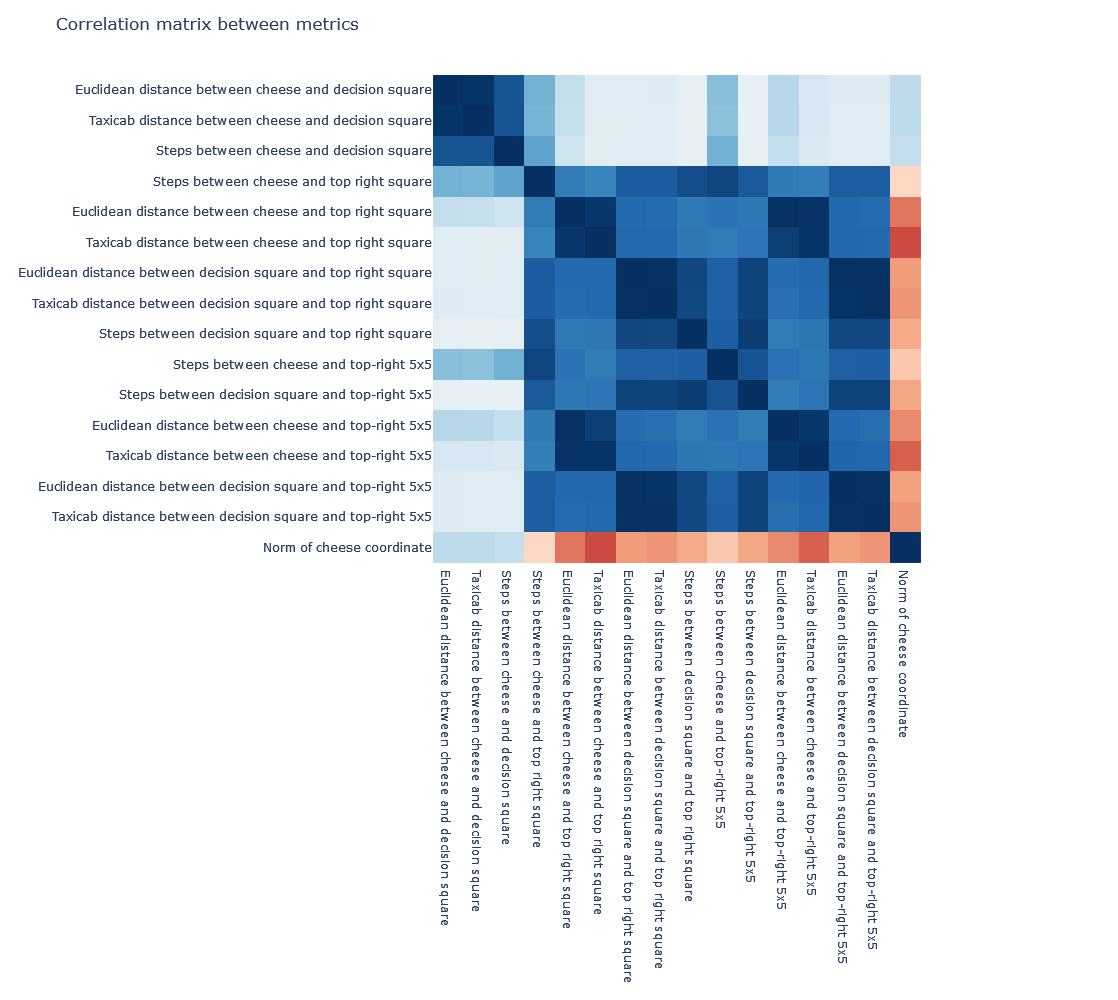

In [48]:
# Show the correlation matrix in plotly
final_metrics = ["euc_dist_cheese_decision_square"]

correlations = np.zeros((len(recorded_metrics), len(recorded_metrics)))
for i, metric1 in enumerate(recorded_metrics.keys()):
    for j, metric2 in enumerate(recorded_metrics.keys()):
        correlations[i, j] = np.corrcoef(
            recorded_metrics[metric1], recorded_metrics[metric2]
        )[0, 1]

# Show the correlation matrix in plotly, with a colorbar
# On mouse over, show the name of each metric
corrmap = px.imshow(
    correlations,
    labels=dict(x="Metric 1", y="Metric 2", color="Correlation"),
    color_continuous_scale="RdBu",
    zmin=-1,
    zmax=1,
)
# Hover template: show the name of each metric, by looking up its value in the x and y lists
corrmap.update_traces(hovertemplate="(%{x}, %{y}) = %{z:.3f} <extra></extra>")

corrmap.update_layout(title_text="Correlation matrix between metrics")
# Don't show numbers over each cell
corrmap.update_traces(text=None)
# Show x and y axis labels
corrmap.update_xaxes(
    ticktext=list(map(english_attr, recorded_metrics.keys())),
    tickvals=list(range(len(recorded_metrics.keys()))),
)

corrmap.update_yaxes(
    ticktext=list(map(english_attr, recorded_metrics.keys())),
    tickvals=list(range(len(recorded_metrics.keys()))),
)

# Hide x and y axis titles
corrmap.update_xaxes(title_text="")
corrmap.update_yaxes(title_text="")

# Hide the color bar
corrmap.update_layout(coloraxis_showscale=False)

# Make size of plot a bit bigger
corrmap.update_layout(width=1000, height=1000)
corrmap.show()

And here are the strongest correlations:

In [49]:
# Get the top k absolute value correlations, ignoring diagonals
k = 50
len_diagonal = len(correlations)
topk = np.argsort(np.abs(correlations).flatten())[-(k + len_diagonal) :][
    ::-1
]  # Diagonal will be 1, so just add in len_diagonal

# Print the top k correlations in a pretty table
table = prettytable.PrettyTable()
table.field_names = map(bold_text, ["Metric 1", "Correlation", "Metric 2"])

for i in topk:
    # Get the row and column of the correlation
    row, col = i // len(correlations), i % len(correlations)
    # Ignore the diagonal and the lower triangle
    if row >= col:
        continue
    # Get the metric names
    metric1, metric2 = (
        list(recorded_metrics.keys())[row],
        list(recorded_metrics.keys())[col],
    )
    # Add the row to the table
    table.add_row(
        [
            format_attr(metric1),
            f"{correlations[row, col]:.3f}",
            format_attr(metric2),
        ]
    )

print(table)

+-----------------------------------------------------------------+-------------+---------------------------------------------------------------+
|                             Metric 1                            | Correlation |                            Metric 2                           |
+-----------------------------------------------------------------+-------------+---------------------------------------------------------------+
| Euclidean distance between decision square and top right square |    0.995    |  Euclidean distance between decision square and top-right 5x5 |
| Euclidean distance between decision square and top right square |    0.995    | Taxicab distance between decision square and top right square |
|      Euclidean distance between cheese and top right square     |    0.994    |      Euclidean distance between cheese and top-right 5x5      |
| Euclidean distance between decision square and top right square |    0.993    |   Taxicab distance between decision square

In [50]:
def run_regression(attrs: List[str], data_frame: pd.DataFrame):
    """Runs a LASSO-regularized regression on the data using the given attributes. Returns the clf."""
    assert len(attrs) > 0, "Must have at least one attribute to regress upon"
    for attr in attrs:
        assert attr in data_frame, f"Attribute {attr} not in data frame"
    assert "cheese" in data_frame, "Attribute 'cheese' not in data frame"

    x = data_frame[attrs]
    y = np.ravel(data_frame[["cheese"]])

    clf = LogisticRegression(
        random_state=0, solver="liblinear", penalty="l1"
    ).fit(x, y)
    return clf


def compute_avg_accuracy(
    attrs: List[str], data_frame: pd.DataFrame, num_runs: int
) -> float:
    """Runs a LASSO-regularized regression num_runs times on the data using the given attributes. Returns the average accuracy."""
    assert len(attrs) > 0, "Must have at least one attribute to regress upon"
    assert num_runs > 0, "Must run at least one time"

    accuracies = []
    for i in range(num_runs):
        train, test = train_test_split(data_frame, test_size=0.2)
        clf = run_regression(attrs, train)
        accuracies.append(clf.score(test[attrs], test["cheese"]))
    return np.mean(accuracies)


def display_coeff_table(clf: Any, attrs: List[str]):
    """Displays the coefficients for each attribute, printing the label next to each coefficient."""
    assert len(attrs) > 0, "Must have at least one attribute"

    # Print the coefficient for each attribute, printing the label next to each coefficient
    table = prettytable.PrettyTable()
    table.field_names = [bold_text("Attribute"), bold_text("Coefficient")]
    for i, attr in enumerate(attrs):
        table.add_row([format_attr(attr), f"{clf.coef_[0][i]:.3f}"])

    # Add a row for the intercept
    table.add_row(["Intercept", f"{clf.intercept_[0]:.3f}"])
    print(table)

# Using maze features to predict whether the mouse got the cheese 

In [51]:
keys = list(recorded_metrics.keys())
data = {key: recorded_metrics[key] for key in keys}
df = pd.DataFrame(data)

df = stats.zscore(
    df
)  # zscore standardizes the data by subtracting the mean and dividing by the standard deviation

# Now we want to add the cheese column to the dataframe
df["cheese"] = pd.DataFrame(
    {"cheese": [(runs[i].got_cheese) for i in range(len(runs))]}
)

# Choose which keys to regress upon
attributes = [
    "steps_between_cheese_5x5",
    "euc_dist_cheese_5x5",
    "steps_between_decision_square_5x5",
    "euc_dist_decision_square_5x5",
    "steps_between_cheese_top_right",
    "euc_dist_cheese_top_right",
    "steps_between_decision_square_top_right",
    "euc_dist_decision_square_top_right",
    "steps_between_cheese_decision_square",
    "euc_dist_cheese_decision_square",
    "cheese_coord_norm",
]

n_runs = 50

avg_accuracy = 0
avg_coefficients = np.zeros(len(attributes) + 1)  # Add one for the intercept
# We reduce variance in the score by running the regression multiple times
for x in range(n_runs):
    train, test = train_test_split(df, test_size=0.2)

    clf = run_regression(attributes, train)
    avg_coefficients[:-1] = (
        clf.coef_[0] + avg_coefficients[:-1]
    )  # Update all but last entry with coeffs
    avg_coefficients[-1] += clf.intercept_[0]  # Last entry is the intercept

    x = test[attributes]
    y = np.ravel(test[["cheese"]])
    avg_accuracy += clf.score(x, y)

avg_accuracy /= n_runs
avg_coefficients /= n_runs
# Print the coefficient for each attribute, printing the label next to each coefficient (for the last run)
display_coeff_table(clf, attributes)
# print(avg_coefficients / n_runs) # TODO show what avg coefficients are
print(
    f"The average regression accuracy is {avg_accuracy:.3f}, averaged over"
    f" {n_runs} regressions."
)

# Record the sign of the coefficients for each attribute
regression_coeff_signs = {
    attr: clf.coef_[0][i] > 0
    for i, attr in enumerate(attributes)
    if attr in claimed_attributes
}

+-----------------------------------------------------------------+-------------+
|                            Attribute                            | Coefficient |
+-----------------------------------------------------------------+-------------+
|              Steps between cheese and top-right 5x5             |    -0.253   |
|       Euclidean distance between cheese and top-right 5x5       |    0.000    |
|         Steps between decision square and top-right 5x5         |    1.133    |
|   Euclidean distance between decision square and top-right 5x5  |    0.000    |
|            Steps between cheese and top right square            |    -0.062   |
|      Euclidean distance between cheese and top right square     |    -2.383   |
|        Steps between decision square and top right square       |    0.000    |
| Euclidean distance between decision square and top right square |    0.000    |
|             Steps between cheese and decision square            |    -1.134   |
|      Euclidean

In [52]:
cheese_rate = sum(df["cheese"]) / len(df["cheese"])
max_baseline = max(
    cheese_rate, 1 - cheese_rate
)  # Always predict "cheese" or "no cheese"
print(
    'Accuracy of the trivial "always yes" or "always no" predictor:'
    f" {max_baseline:.3f}"
)

Accuracy of the trivial "always yes" or "always no" predictor: 0.848


Let's examine whether it's predictively useful to know the Euclidean
distance between the cheese and the decision square, given that we
already know the step distance. (Spoiler: It is!)

In [53]:
attr_lists = [
    ["steps_between_cheese_decision_square"],
    [
        "steps_between_cheese_decision_square",
        "euc_dist_cheese_decision_square",
    ],
]
n_regressions = 100

for attr_list in attr_lists:
    print()
    clf = run_regression(attr_list, df)
    display_coeff_table(clf, attr_list)
    print(
        "The accuracy for these attributes is"
        f" {compute_avg_accuracy(attr_list, df, n_regressions):.3f}, averaged"
        f" over {n_regressions} regressions."
    )
    print()


+------------------------------------------+-------------+
|                Attribute                 | Coefficient |
+------------------------------------------+-------------+
| Steps between cheese and decision square |    -1.072   |
|                Intercept                 |    2.050    |
+------------------------------------------+-------------+
The accuracy for these attributes is 0.866, averaged over 100 regressions.


+-------------------------------------------------------+-------------+
|                       Attribute                       | Coefficient |
+-------------------------------------------------------+-------------+
|        Steps between cheese and decision square       |    -0.697   |
| Euclidean distance between cheese and decision square |    -0.467   |
|                       Intercept                       |    2.093    |
+-------------------------------------------------------+-------------+
The accuracy for these attributes is 0.849, averaged over 100 re

# Stress-testing our results
Overall, the features we claimed to be important, still seem to be important, although to different strengths. The claimed attributes don't exhibit sign-flips in a range of conditions.

## Trying to re-pinpoint the claimed features
Peli Grietzer originally found the bolded attributes using the following methodology, which he describes as follows:

> I did multiple logistic regression with all the factors at once, then did a multiple logistic regression with all-factors-except-x for each x and wrote down which factors caused test accuracy loss when dropped.
>
> Four factors caused non-trivial test accuracy loss, so I took those four factors and did a multiple logistic regression on these four factors, and saw that the test accuracy was as good as with all factors.
>
> I then tested dropping each of the four factors and using just three, and saw that there was a non-trivial drop in test accuracy for each of them.
>
> I then tested adding one additional factor to the four factors, trying every unused factor and seeing no increase in test accuracy.

This section implements that methodology. This doesn't seem to replicate, which is some evidence against our initial results -- there's less of a reason to pick out the four attributes we did.

In [54]:
# Do a multiple logistic regression with all-attributes-except-x for each x and store which attributes caused test accuracy loss when dropped.
relative_drop = 0.005
accuracy_drop_attrs = []
num_runs = 5

for attr in recorded_metrics.keys():
    attr_accuracy = compute_avg_accuracy(
        list(recorded_metrics.keys() - {attr}), df, num_runs
    )
    if attr_accuracy < avg_accuracy * (1 - relative_drop):
        accuracy_drop_attrs.append(attr)

print(
    f"When excluded, the following attributes caused a >{relative_drop*100}%"
    " relative drop in accuracy:"
)
for attr in accuracy_drop_attrs:
    print(f"\t{format_attr(attr)}")

When excluded, the following attributes caused a >0.5% relative drop in accuracy:
	Taxicab distance between cheese and decision square
	Taxicab distance between decision square and top right square
	Steps between decision square and top right square


In [55]:
# Take these attributes and run a multiple logistic regression on these attributes, and check that the test accuracy was as good as with all attributes.
if len(accuracy_drop_attrs) > 0:
    new_accuracy = compute_avg_accuracy(accuracy_drop_attrs, df, num_runs=10)
    print(
        "The accuracy of the regression with the dropped attributes is"
        f" {new_accuracy:.3f}."
    )
    if new_accuracy < avg_accuracy * (1 - relative_drop):
        print(
            "Accuracy of regression with dropped attributes is not as good as"
            " with all attributes."
        )

    # Try dropping each of the attributes that caused a drop in accuracy and verify that the accuracy drops significantly
    for attr in accuracy_drop_attrs:
        attr_accuracy = compute_avg_accuracy(
            list(recorded_metrics.keys() - {attr}), df, num_runs=1
        )
        if attr_accuracy > avg_accuracy * (1 - relative_drop):
            print(
                f"The accuracy of the regression with ({format_attr(attr)})"
                " dropped is not significantly lower than with all attributes"
                f" ({avg_accuracy:.3f})."
            )
    print()

    # Try adding each of the attributes that did not cause a drop in accuracy and see if the accuracy increases significantly
    for attr in list(recorded_metrics.keys() - set(accuracy_drop_attrs)):
        attr_accuracy = compute_avg_accuracy(
            list(recorded_metrics.keys() | {attr}), df, num_runs=1
        )
        if attr_accuracy > avg_accuracy * (1 - relative_drop):
            print(
                f"The accuracy of the regression with ({format_attr(attr)})"
                " added is not significantly higher than with all attributes."
            )

The accuracy of the regression with the dropped attributes is 0.841.
Accuracy of regression with dropped attributes is not as good as with all attributes.
The accuracy of the regression with (Taxicab distance between cheese and decision square) dropped is not significantly lower than with all attributes (0.904).
The accuracy of the regression with (Taxicab distance between decision square and top right square) dropped is not significantly lower than with all attributes (0.904).
The accuracy of the regression with (Steps between decision square and top right square) dropped is not significantly lower than with all attributes (0.904).

The accuracy of the regression with (Euclidean distance between decision square and top right square) added is not significantly higher than with all attributes.
The accuracy of the regression with (Steps between cheese and top-right 5x5) added is not significantly higher than with all attributes.
The accuracy of the regression with (Steps between cheese a

In [56]:
claimed_accuracy = compute_avg_accuracy(claimed_attributes, df, num_runs=10)
clf = run_regression(claimed_attributes, df)
display_coeff_table(clf, claimed_attributes)
print(
    f"Claimed attributes obtain accuracy of {claimed_accuracy:.3f}, which is"
    f" {(avg_accuracy - claimed_accuracy)*100:.3f} absolute percent less than"
    " when all features are used."
)

+--------------------------------------------------------------+-------------+
|                          Attribute                           | Coefficient |
+--------------------------------------------------------------+-------------+
|           Steps between cheese and decision square           |    -1.147   |
|    Euclidean distance between cheese and decision square     |    -0.082   |
|    Euclidean distance between cheese and top right square    |    -2.308   |
| Euclidean distance between decision square and top-right 5x5 |    0.731    |
|                          Intercept                           |    3.012    |
+--------------------------------------------------------------+-------------+
Claimed attributes obtain accuracy of 0.913, which is -0.835 absolute percent less than when all features are used.


## Robustness to regressing on random subsets of attributes

When regressing on related factors (e.g. Euclidean and step distance to cheese from decision square), we might wonder: "Did these coefficients only come out this way as a fluke of the regression itself?". For example, factor subset X may induce feature $a$ to have a positive coefficient, while a different factor subset Y induces $a$ with a negative regression coefficient. Encouragingly, the signs of our claimed attributes are highly robust to which set of factors we regress upon.

In [57]:
def run_subset_regression(
    data_frame: pd.DataFrame, n_attrs: int, verbose: bool = False
) -> Tuple[Any, List[str]]:
    """Runs a regression on the data frame using a random subset of n_attrs attributes. Returns the clf and the attributes used."""
    attrs = random.sample(list(recorded_metrics.keys() - {"cheese"}), n_attrs)
    clf = run_regression(attrs, train)

    if verbose:
        display_coeff_table(clf, attrs)

    return clf, attrs


def check_claimed_signs(
    clf: Any, attrs: List[str], data_frame: pd.DataFrame, verbose: bool = False
) -> Dict[str, int]:
    """Checks if the signs of the regression coefficients for the given attributes match regression_coeff_signs. Returns a dictionary which counts the number of times each attribute had the wrong sign."""
    counters = defaultdict(int)

    for i, attr in enumerate(attrs):
        if attr not in regression_coeff_signs.keys() or attr in counters:
            continue
        assert attr in data_frame, f"Attribute {attr} not in data frame"
        if (clf.coef_[0][i] >= 0) != regression_coeff_signs[attr]:
            if verbose:
                print(
                    f"Attribute {attr} has incorrect sign; expected"
                    f" {regression_coeff_signs[attr]} but got"
                    f" {clf.coef_[0][i] >= 0}"
                )
                display_coeff_table(clf, attrs)
            counters[
                attr
            ] += 1  # Increment the attribute that had the incorrect sign
    return counters


# Run the regression multiple times and check the signs
# See distribution of sign errors over multiple runs
counter = {attr: 0 for attr in claimed_attributes}
n_rand_runs = 200
for x in range(n_rand_runs):
    # Draw a random number of attributes to use
    n_attrs = random.randint(1, len(recorded_metrics.keys()) - 1)
    clf, attrs = run_subset_regression(train, n_attrs)
    new_counter = check_claimed_signs(clf, attrs, train, verbose=False)
    for key in new_counter.keys():
        counter[key] += new_counter[key]

In [58]:
# Print a table displaying the percentage of times each attribute had the wrong sign
sign_table = prettytable.PrettyTable()
sign_table.field_names = ["Attribute", "% of runs with flipped sign"]
for key in counter.keys():
    sign_table.add_row([english_attr(key), counter[key] / n_rand_runs * 100])
print(sign_table)

+--------------------------------------------------------------+-----------------------------+
|                          Attribute                           | % of runs with flipped sign |
+--------------------------------------------------------------+-----------------------------+
|           Steps between cheese and decision square           |             0.0             |
|    Euclidean distance between cheese and decision square     |             6.0             |
|    Euclidean distance between cheese and top right square    |             22.0            |
| Euclidean distance between decision square and top-right 5x5 |             50.0            |
+--------------------------------------------------------------+-----------------------------+


## Variation inflation factor (VIF)
As I (Alex) understand it, VIF measures how much of the variance of the regression coefficients are due to multicollinearity. Restricting our attention to the features mentioned in the post, the VIF scores are medium-high (but tolerable), while including all features leads to extremely high VIF. This is some weak further evidence that our regression was not a statistical fluke or modeling decision (but I'm not a statistician!).

In [59]:
# Let's compute VIF (variance inflation factor) for each attribute
# This is a measure of how much the variance of the coefficient is inflated due to multicollinearity
# Above 5 is usually considered to be a sign of that
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Ignore runtime warnings due to division by 0 from R2=1
import warnings

warnings.filterwarnings("ignore")

for attrs in [claimed_attributes, recorded_metrics.keys()]:
    print()
    print(
        "VIF for claimed attributes"
        if attrs == claimed_attributes
        else "VIF for all attributes"
    )
    vif = pd.DataFrame()
    vif["Features"] = df[attrs].columns
    vif["VIF"] = [
        variance_inflation_factor(df[attrs].values, i)
        for i in range(df[attrs].shape[1])
    ]

    print(vif)


VIF for claimed attributes
                               Features       VIF
0  steps_between_cheese_decision_square  4.057181
1       euc_dist_cheese_decision_square  4.135968
2             euc_dist_cheese_top_right  2.824415
3          euc_dist_decision_square_5x5  2.707579

VIF for all attributes
                                   Features          VIF
0           euc_dist_cheese_decision_square    29.897902
1          taxi_dist_cheese_decision_square    30.168496
2      steps_between_cheese_decision_square          inf
3            steps_between_cheese_top_right          inf
4                 euc_dist_cheese_top_right  1006.961628
5                taxi_dist_cheese_top_right   193.181512
6        euc_dist_decision_square_top_right  1123.675729
7       taxi_dist_decision_square_top_right   569.879727
8   steps_between_decision_square_top_right          inf
9                  steps_between_cheese_5x5    13.811472
10        steps_between_decision_square_5x5    25.004002
11            